# Abstract

This project aims to investigate the differences in electroencephalography (EEG) signals between individuals with Alzheimer’s disease (AD) and controls. We used two datapoints from Mitiadous et al. (2023)[1], which contains scalp EEG recordings of AD patients, and healthy controls under eyes-closed rest. In this project, we will first apply signal processing techniques including filtering and artifact rejection remove noise and isolate the frequency range of interest. Our methodology includes the application of the discrete Fourier transform (DFT) to examine spectral components, followed by the computation of power spectral density (PSD) via the Welch method. Through this approach, we aim to quantify the relative band power across different frequency bands, allowing for a detailed comparison of neural activity between the two subjects.

# Exploratory Data Analysis

Below is the dataset description provided by our TA:

>This dataset provides resting-state EEG recordings from individuals with Alzheimer’s disease (AD), frontotemporal dementia (FTD), and healthy controls, collected using a clinical EEG system with 19 scalp electrodes during an eyes-closed resting state. The dataset includes 36 AD patients, 23 FTD patients, and 29 healthy age-matched subjects, with Mini-Mental State Examination (MMSE) scores reported for each. EEG signals were recorded using a monopolar montage, and both raw and preprocessed EEG data are available in BIDS format. Preprocessing involved artifact subspace reconstruction and independent component analysis for denoising. This dataset has high reuse potential for studying EEG-based biomarkers for dementia, brain connectivity alterations, and machine learning applications in neurodegenerative disease diagnosis.
>
>- Two individual EEG data included(Alzheimer’s disease - subject_001, Healthy Control - subject_027)
>- The sampling rate was 500 Hz and the resolution was 10 uV/mm
>- Three channel included: `Fp1`, `Fp2`, `F3`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, firwin, filtfilt, welch, freqz, lfilter

np.random.seed = 118
F_s = 500

Load in the dataset and transform it into a pandas dataframe.

In [2]:
Control = np.load("./dataset/Control_EEG_sub_027.npy")
AD = np.load("./dataset/AD_EEG_sub_001.npy")

feature_names = ['Fp1', 'Fp2', 'F3']
df_control = pd.DataFrame(Control.T, columns=feature_names)
df_AD = pd.DataFrame(AD.T, columns=feature_names)

df_AD.head()

,Fp1,Fp2,F3
0,-0.000190,-0.000142,-0.000107
1,-0.000180,-0.000137,-0.000100
2,-0.000167,-0.000135,-0.000106
3,-0.000160,-0.000133,-0.000105
4,-0.000159,-0.000124,-0.000104


Since the usual measurement for EEG studies is $\mu V$, we upscale the entire dataset by $10^6$

In [3]:
df_AD *= 1e6
df_control *= 1e6
df_AD.head()

,Fp1,Fp2,F3
0,-189.892563,-141.845688,-107.373039
1,-180.419907,-137.353500,-100.048820
2,-166.992172,-135.058578,-105.761711
3,-160.205063,-132.958969,-105.322258
4,-159.326157,-124.462883,-104.150383


Display the raw EEG data of two subjects.

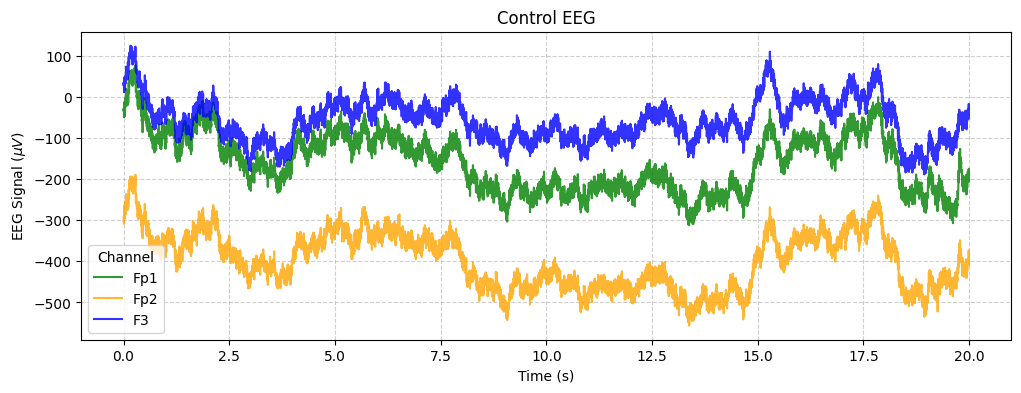

In [4]:
def plot_EEG (df,title):
    t = df.index/F_s
    plt.figure(figsize=(12, 4))
    plt.plot(t,df["Fp1"], color = "green", label = "Fp1", alpha = 0.8)
    plt.plot(t,df["Fp2"], color = "orange", label = "Fp2", alpha = 0.8)
    plt.plot(t,df["F3"], color = "blue", label = "F3", alpha = 0.8)
    plt.xlabel('Time (s)')
    plt.ylabel(r'EEG Signal $(\mu V)$')
    plt.title(title)
    plt.legend(title="Channel")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_EEG(df_control, "Control EEG")

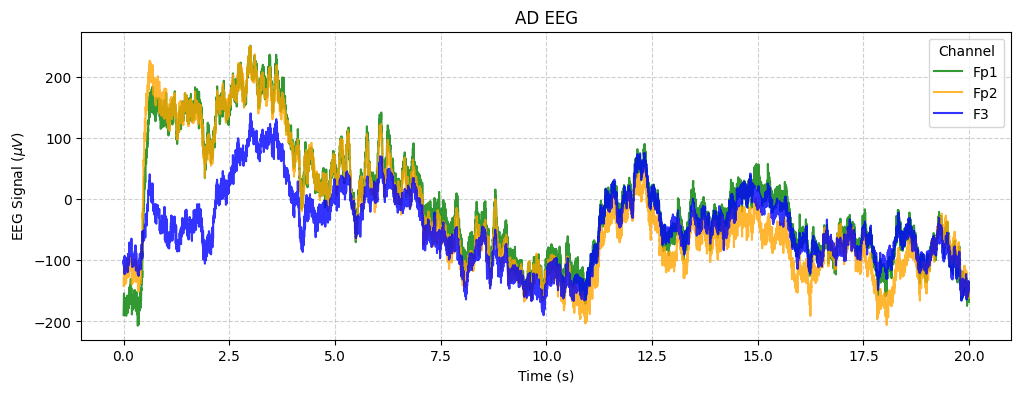

In [5]:
plot_EEG(df_AD, "AD EEG")

The unprocessed data shows signs of high-frequency noise as the range of the signal varies from $\pm 200 \mu V$, which is abnormal for calm state EEG. Preprocessing and cleaning is needed before doing further analysis.

# Preprocessing
In the original dataset paper, a preprocessing pipeline is applied as the following:

> First, a Butterworth band-pass filter 0.5-45 Hz was applied and the signals were re-referenced to A1-A2. Then, the Artifact Subspace Reconstruction routine (ASR) which is an EEG artifact correction method included in the EEGLab Matlab software was applied to the signals, removing bad data periods which exceeded the max acceptable 0.5 second window standard deviation of 17, which is considered a conservative window. Next, the Independent Component Analysis (ICA) method (RunICA algorithm) was performed, transforming the 19 EEG signals to 19 ICA components. ICA components that were classified as “eye artifacts” or “jaw artifacts” by the automatic classification routine “ICLabel” in the EEGLAB platform were automatically rejected. It should be noted that, even though the recording was performed in a resting state, eyes-closed condition, eye artifacts of eye movement were still found at some EEG recordings.

Since we do not have the whole data set, we will be focusing on the filtering part.

In [6]:
lowcut = 0.5
highcut = 45

## Butterworth Filter
Below is the Butterworth band-pass filter suggested from ["scipy-cookbook"](https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html). It also included a useful graph displaying how the order of butter reflected to the shape of the filter.

In [7]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

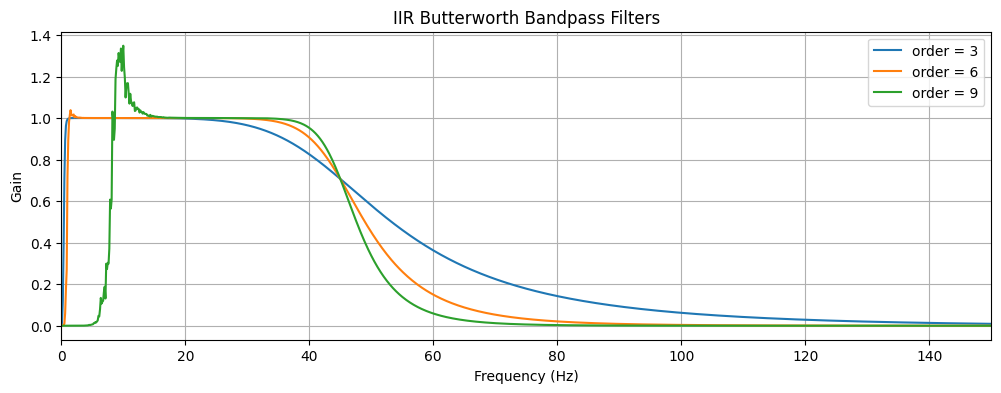

In [8]:
plt.figure(figsize=(12, 4))

for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, F_s, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((F_s * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.title('IIR Butterworth Bandpass Filters')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.xlim(0,150)
plt.grid(True)
plt.legend(loc='best')
plt.show()

Notice that when `order = 9`, there is a strange spike in the filter. This is likely because of the recursive calculation of the IIR filter. So in our actual filter, we used `order = 5` to prevent this from happening.

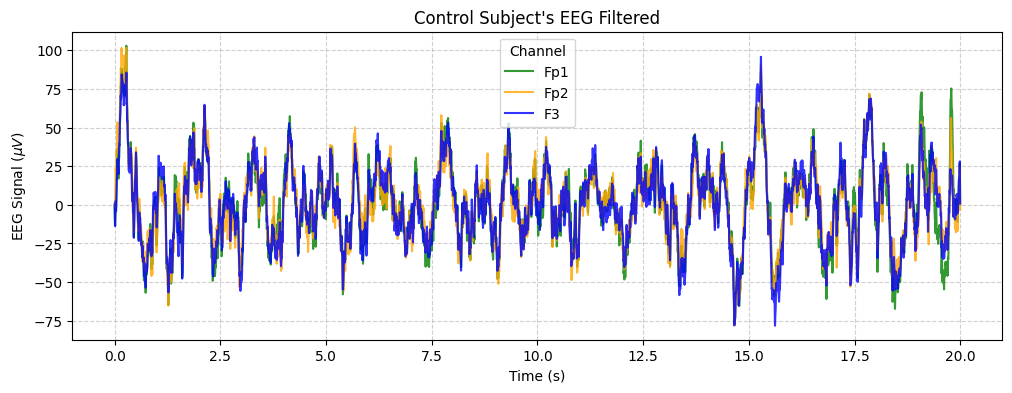

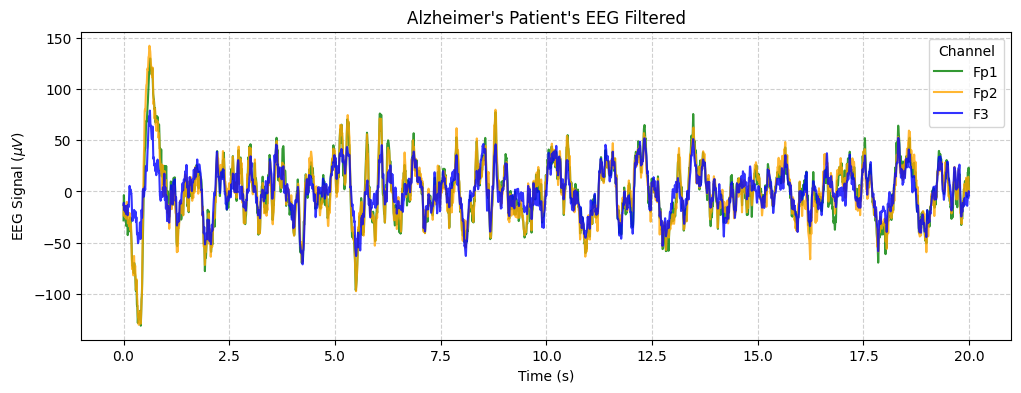

In [9]:
df_control_IIRfiltered = df_control.copy()
df_AD_IIRfiltered = df_AD.copy()

for col in df_control.columns:
    df_control_IIRfiltered[col] = butter_bandpass_filter(df_control[col], lowcut, highcut,F_s, order = 5)
for col in df_AD.columns:
    df_AD_IIRfiltered[col] = butter_bandpass_filter(df_AD[col], lowcut, highcut, F_s, order = 5)


plot_EEG(df_control_IIRfiltered, "Control Subject's EEG Filtered")
plot_EEG(df_AD_IIRfiltered, "Alzheimer's Patient's EEG Filtered")

## Why Not an IIR Filter
In class we learned a lot a bout finite __impulse response filters__ (FIR), but the paper used a __infinite response filter__ (IIR). One major reason is because FIR filters need a very high order to achieve the same cutoff as a IIR filter. The original study has 88 subjects with datapoints millions of datapoints, using a high order FIR filter is very inefficient.

But in our study, we only have 2 subjects with 20 seconds of data. This makes it easy for us to use FIR filters without worrying about computation cost. IIR also has a potential disadvantage: since it utilizes feedback loop, without caution one can create significant artifact after applying them. FIR filters only use original data which is safe.

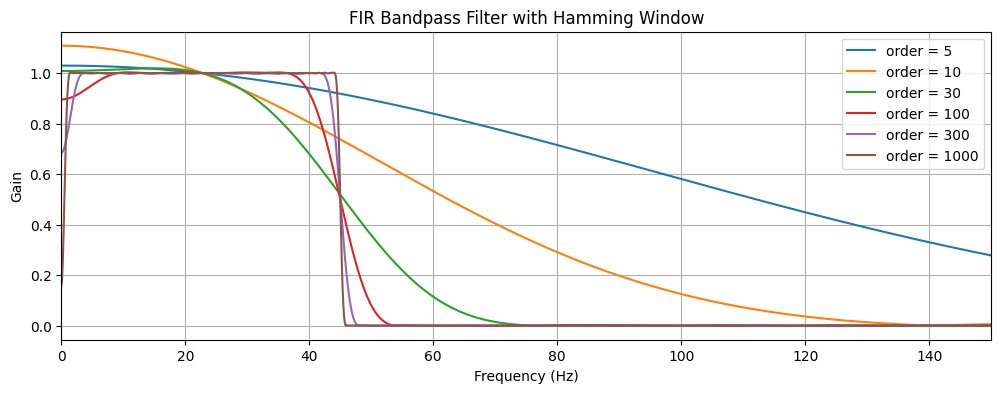

In [10]:
nyquist = F_s / 2
low = lowcut / nyquist
high = highcut / nyquist

plt.figure(figsize=(12, 4))

for order in [5,10,30,100,300,1000]:
    fir_coeffs = firwin(order, [low,high], pass_zero=False, window="hamming")

    w, h = freqz(fir_coeffs, worN=2000)
    freq = w * F_s / (2 * np.pi)

    plt.plot(freq, abs(h), label=f'order = {order}')

plt.title('FIR Bandpass Filter with Hamming Window')
plt.xlabel('Frequency (Hz)')
plt.xlim(0,150)
plt.ylabel('Gain')
plt.grid()
plt.legend()
plt.show()

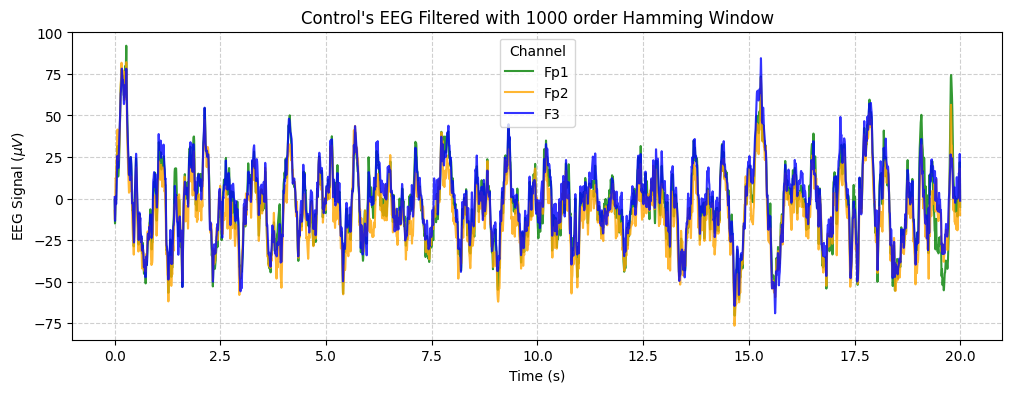

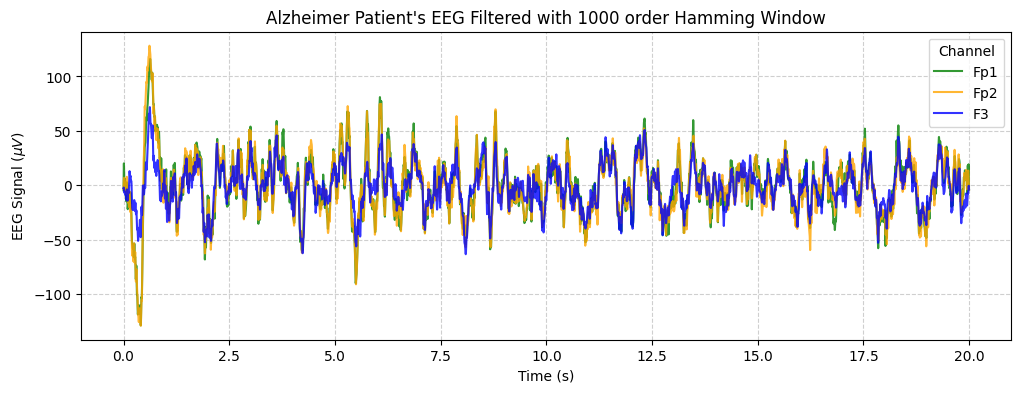

In [11]:
order = 1000

fir_coef = firwin(order, [low, high], pass_zero=False, window="hamming")

df_control_FIRfiltered = df_control.copy()
df_AD_FIRfiltered = df_AD.copy()

for col in df_control.columns:
    df_control_FIRfiltered[col] = filtfilt(fir_coef, 1.0, df_control[col])

for col in df_AD.columns:
    df_AD_FIRfiltered[col] = filtfilt(fir_coef, 1.0, df_AD[col])

plot_EEG(df_control_FIRfiltered, "Control's EEG Filtered with 1000 order Hamming Window")
plot_EEG(df_AD_FIRfiltered, "Alzheimer Patient's EEG Filtered with 1000 order Hamming Window")

Another problem arise when we have extremely high order: transient effect. Since we only have 20 seconds of data, if we use a FIR response, then for the first few seconds, the filter is still "warming up" and we lost 10% of our data just to initialize the filter itself. This is why we used `filtfilt`, which filters the signal forward and backwards, eliminating this effect.

# PSD Analysis

## Fourier Transform

We first use the Fast __Fourier Transform (FFT)__ which converts time-domain EEG signals into the frequency domain, allowing us to estimate the __Power Spectral Density (PSD)__. FFT-based PSD provides a direct computation with higher frequency resolution which may introduce more variability due to the lack of averaging. Later on, we will be combating this issue by using Welch's method, which averages overlapping segments of the signal to reduce noise, Both methods use the same spectral characteristics, which confirms the validity of our results and ensures that the observed EEG slowing in Alzheimer's patients is a strong finding.

FFT is useful because high-frequency resolution allows us to detect small differences in the EEG power spectrum, which is important for detecting frequency-specific changes in brain activity. For our project, it helps us see which frequency is dominant in Alzheimers patients which reflects EEG slowing. Also, since it provides a detailed spectral decomposition, we can use it to compare power distributions between Alzheimers patients and controls.

First we define the function `compute_psd_fft()`, which calcluates the PSD by applying the FFT to the EEG signal, and then use `plot_PSD_fft()` to visualize the FFT-based PSD for each EEG channel (Fp1, Fp2, F3). This provides a frequency-domain representation of brain activity and allows us to compare spectral differences between Alzheimer's patients and control subjects. We also labeled the suggested frequency bands in the original paper, with:

> - Delta Band: 0.5–4 Hz
> - Theta Band: 4–8 Hz
> - Alpha Band: 8–13 Hz
> - Beta Band: 13–25 Hz
> - Gamma Band: 25–45 Hz

In [12]:
def compute_psd_fft(signal, fs):
    N = len(signal)
    fft_vals = np.fft.rfft(signal)
    fft_freqs = np.fft.rfftfreq(N, d=1/fs)
    psd = (np.abs(fft_vals) ** 2) / N
    return fft_freqs, psd

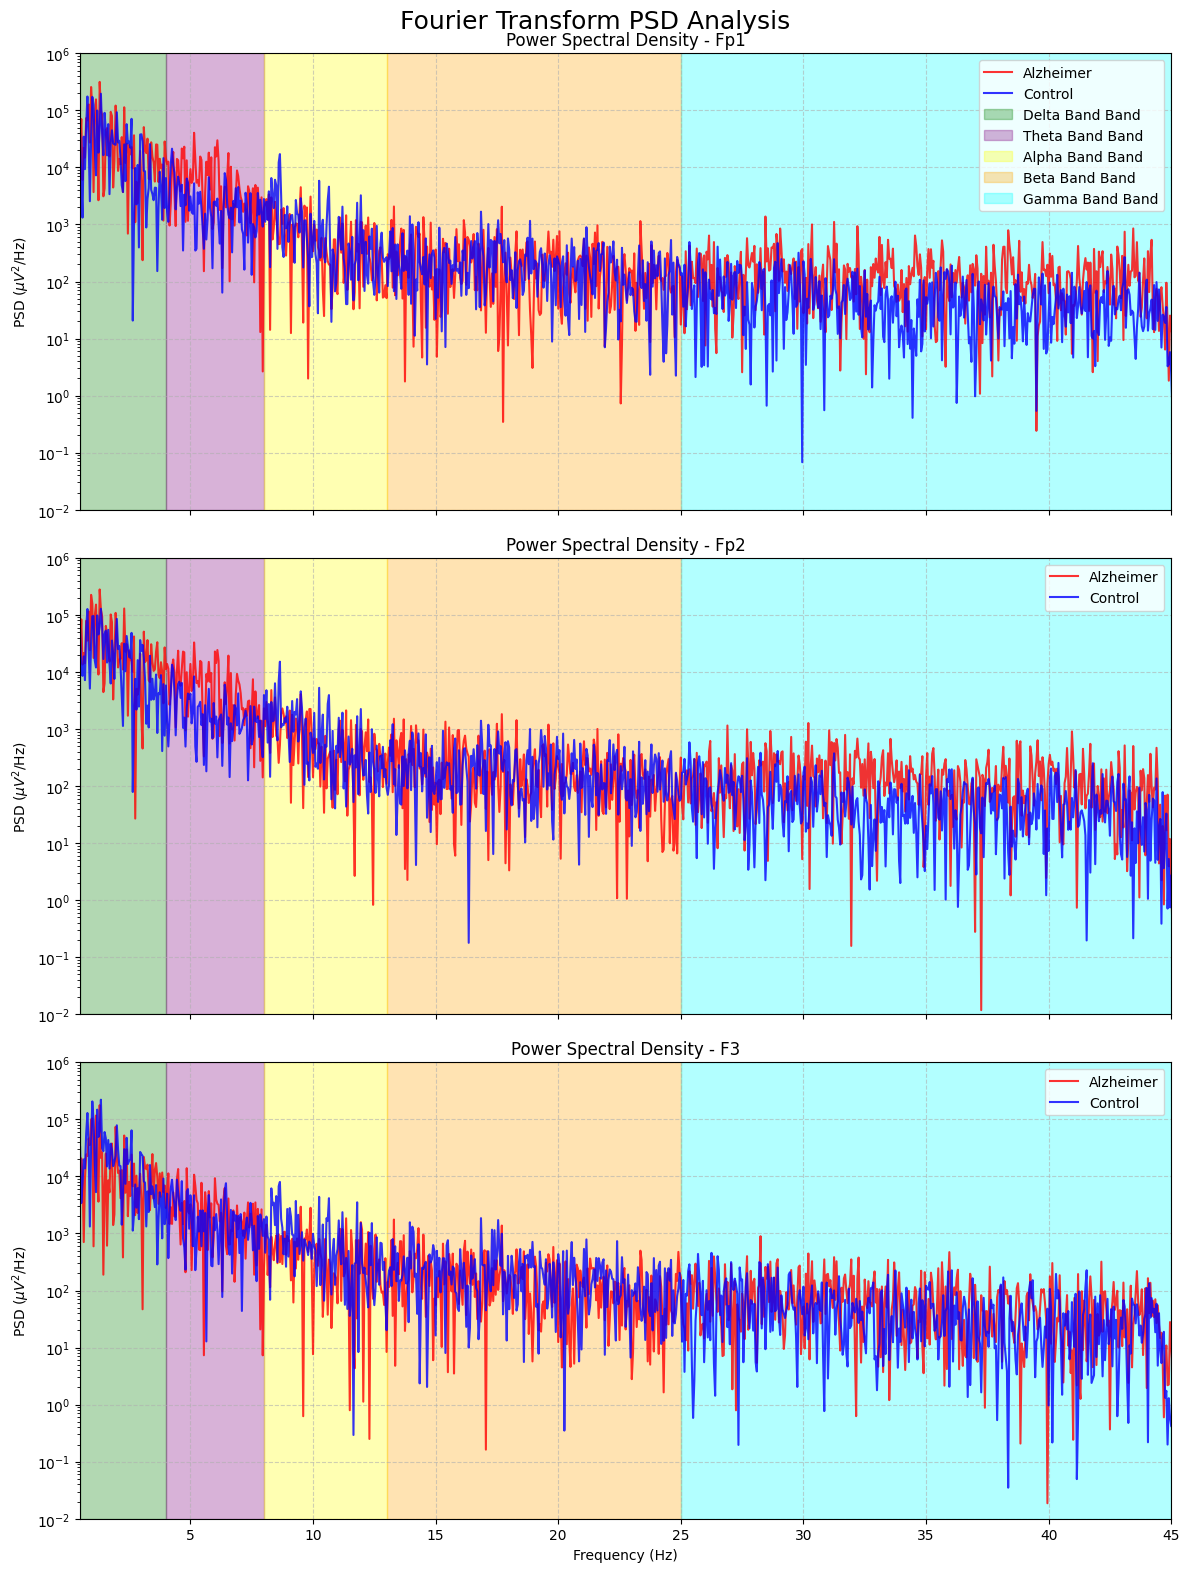

In [13]:
def plot_psd(ax, freqs_AD, psd_AD, freqs_control, psd_control, xlim, ylim, title):
    ax.plot(freqs_AD, psd_AD, label="Alzheimer", color="red", alpha=0.8)
    ax.plot(freqs_control, psd_control, label="Control", color="blue", alpha=0.8)
    
    ax.set_ylabel(r"PSD ($\mu V^2$/Hz)")
    ax.set_title(f"Power Spectral Density - {title}")

    bands = {"Delta Band": (0.5, 4, 'green'),
            "Theta Band": (4, 8, 'purple'),
            "Alpha Band": (8, 13, 'yellow'),
            "Beta Band":  (13, 25, 'orange'),
            "Gamma Band": (25, 45, 'cyan')}

    for name, (low, high, color) in bands.items():
        ax.axvspan(low, high, color=color, alpha=0.3, label=f'{name} Band' if title == "Fp1" else "")

    ax.legend()
    ax.grid(linestyle="--", alpha=0.6)
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

freqs_Fp1_AD, psd_Fp1_AD = compute_psd_fft(df_AD_FIRfiltered["Fp1"].values, F_s)
freqs_Fp1_control, psd_Fp1_control = compute_psd_fft(df_control_FIRfiltered["Fp1"].values, F_s)

freqs_Fp2_AD, psd_Fp2_AD = compute_psd_fft(df_AD_FIRfiltered["Fp2"].values, F_s)
freqs_Fp2_control, psd_Fp2_control = compute_psd_fft(df_control_FIRfiltered["Fp2"].values, F_s)

freqs_F3_AD, psd_F3_AD = compute_psd_fft(df_AD_FIRfiltered["F3"].values, F_s)
freqs_F3_control, psd_F3_control = compute_psd_fft(df_control_FIRfiltered["F3"].values, F_s)


fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)

plot_psd(axes[0], freqs_Fp1_AD, psd_Fp1_AD, freqs_Fp1_control, psd_Fp1_control, (0.5, 45), (1e-2, 1e6), "Fp1")
plot_psd(axes[1], freqs_Fp2_AD, psd_Fp2_AD, freqs_Fp2_control, psd_Fp2_control, (0.5, 45), (1e-2, 1e6), "Fp2")
plot_psd(axes[2], freqs_F3_AD, psd_F3_AD, freqs_F3_control, psd_F3_control, (0.5, 45), (1e-2, 1e6), "F3")

axes[2].set_xlabel("Frequency (Hz)")

fig.suptitle("Fourier Transform PSD Analysis", fontsize=18)
plt.tight_layout()
plt.show()

## Welch's Method

Although FFT is a direct way of seeing the raw PSD differences between the two subjects, it is very noisy. To interpret the result better in terms of frequency bands, we can use the __Welch's Method__, which reduces noise and provides a smoother estimate by averaging multiple segments of the signal. This allows us to compare the power across different frequency bands while minimizing variability. 

We'll first create a function to calculate the PSD and plot the PSD for all 3 EEG channels (`Fp1`, `Fp2`, `F3`). 

In [14]:
def plot_psd_Welch(df_AD, df_control, nperseg=500):
    freqs_Fp1_AD, psd_Fp1_AD = welch(df_AD["Fp1"].values, fs=F_s, nperseg=nperseg)
    freqs_Fp1_control, psd_Fp1_control = welch(df_control["Fp1"].values, fs=F_s, nperseg=nperseg)
    
    freqs_Fp2_AD, psd_Fp2_AD = welch(df_AD["Fp2"].values, fs=F_s, nperseg=nperseg)
    freqs_Fp2_control, psd_Fp2_control = welch(df_control["Fp2"].values, fs=F_s, nperseg=nperseg)
    
    freqs_F3_AD, psd_F3_AD = welch(df_AD["F3"].values, fs=F_s, nperseg=nperseg)
    freqs_F3_control, psd_F3_control = welch(df_control["F3"].values, fs=F_s, nperseg=nperseg)
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    plot_psd(axes[0], freqs_Fp1_AD, psd_Fp1_AD, freqs_Fp1_control, psd_Fp1_control, (0.5, 45), (1e-1, 1e3), "Fp1")
    plot_psd(axes[1], freqs_Fp2_AD, psd_Fp2_AD, freqs_Fp2_control, psd_Fp2_control, (0.5, 45), (1e-1, 1e3), "Fp2")
    plot_psd(axes[2], freqs_F3_AD, psd_F3_AD, freqs_F3_control, psd_F3_control, (0.5, 45), (1e-2, 1e6), "F3")

    axes[2].set_xlabel("Frequency (Hz)")
    fig.suptitle("Welch Method PSD Analysis with nperseg = "+str(nperseg), fontsize=18)
    plt.tight_layout()
    plt.show()

We want to determine what `nperseg` value will best help us determine our problem. Testing different `nperseg` values is essential because it affects two important properties of the PSD: __Frequency Resolution__ and __Variance Reduction__. A larger `nperseg` will increase frequency resolution (i.e distinguish fine details in the EEG spectrum) as well as reduce number of segments, making the estimate more variable. While a smaller `nperseg` will be the vice versa.

First, we make `nperseg` the same as the sampling rate (__500__). 

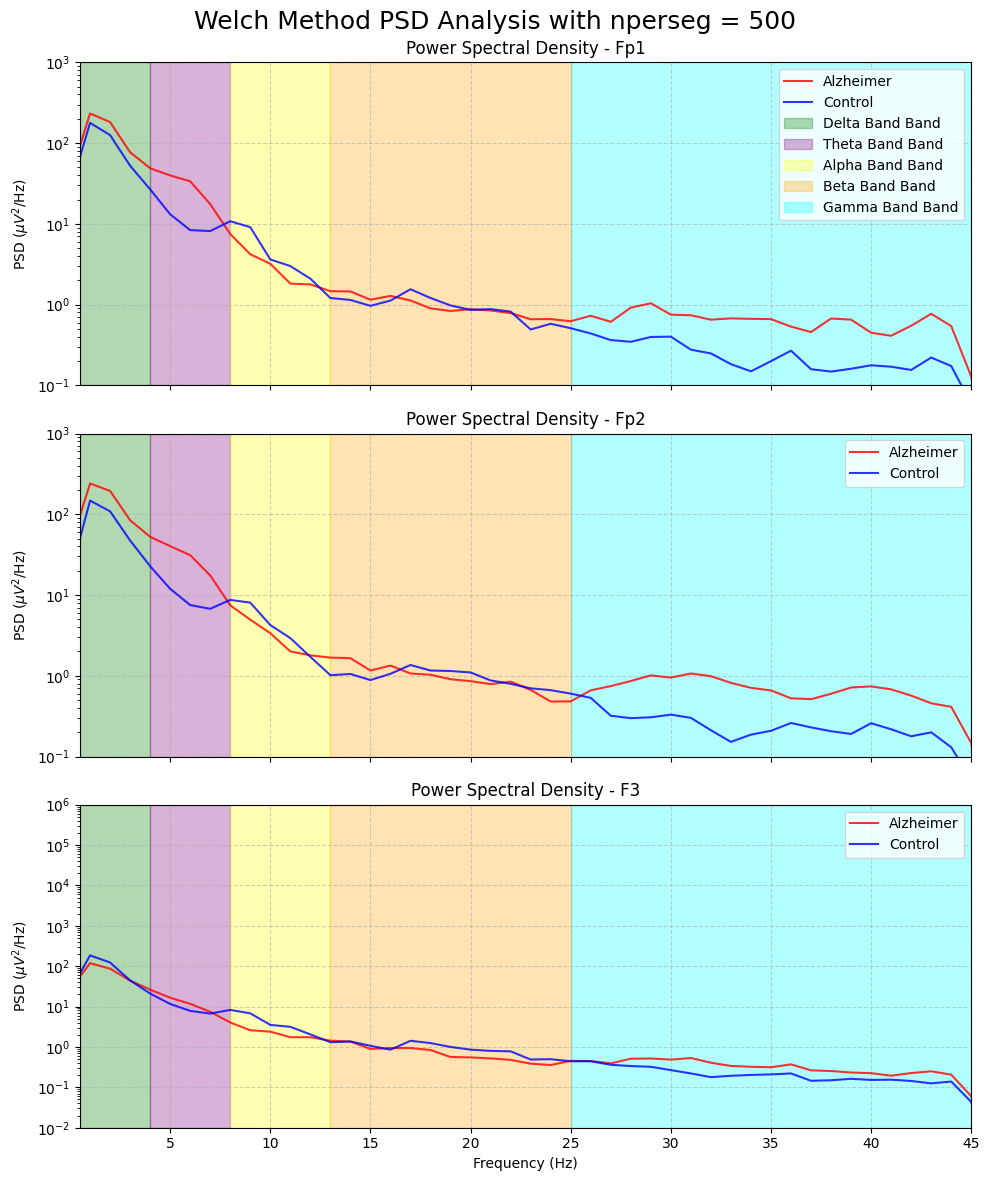

In [15]:
plot_psd_Welch(df_AD_FIRfiltered, df_control_FIRfiltered, nperseg=500)

You can see that the PSD curve is smooth with reduced noise but the __frequency resolution__ is low, so it is harder to distinguish small peaks and be definitive with our conclusion. The differences in frequency bands are less distinct.


Now let's try a higher `nperseg` = 1500.

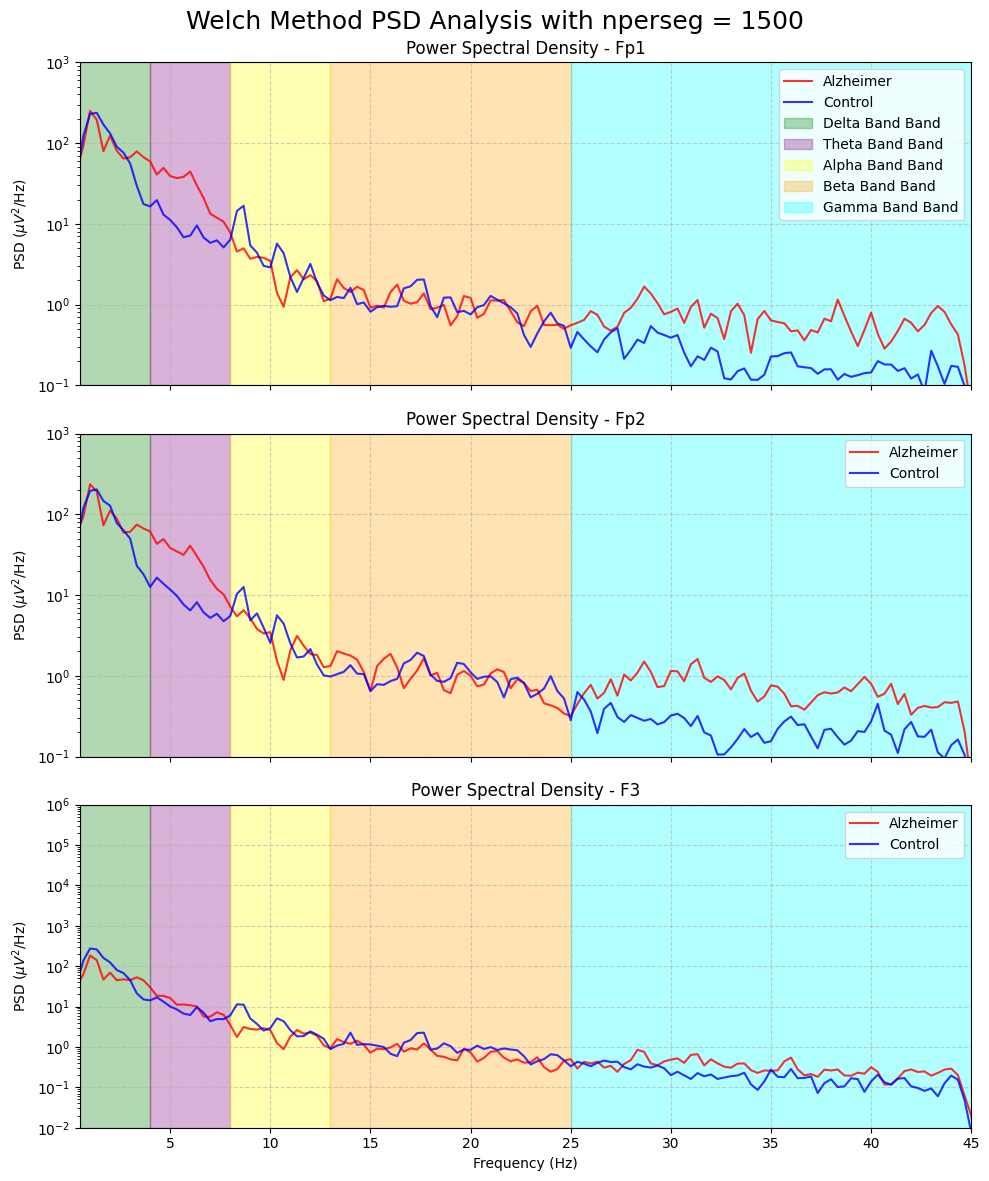

In [ ]:
plot_psd_Welch(df_AD_FIRfiltered, df_control_FIRfiltered, nperseg=1500)

As you can observe, there looks to be a balance between __frequency resolution__ and __smoothness__. Even though the PSD still has some averaging effect, the individual peaks are more visible. This allows us to clearly see the difference in the __Alpha__, __Theta__ and __Alpha__ bands. In channels `FP1` and `FP3`, there is a significant peak in the AD patient's Theta and Gamma band.

Lastly, we try using a high `nperseg` value of 2500.

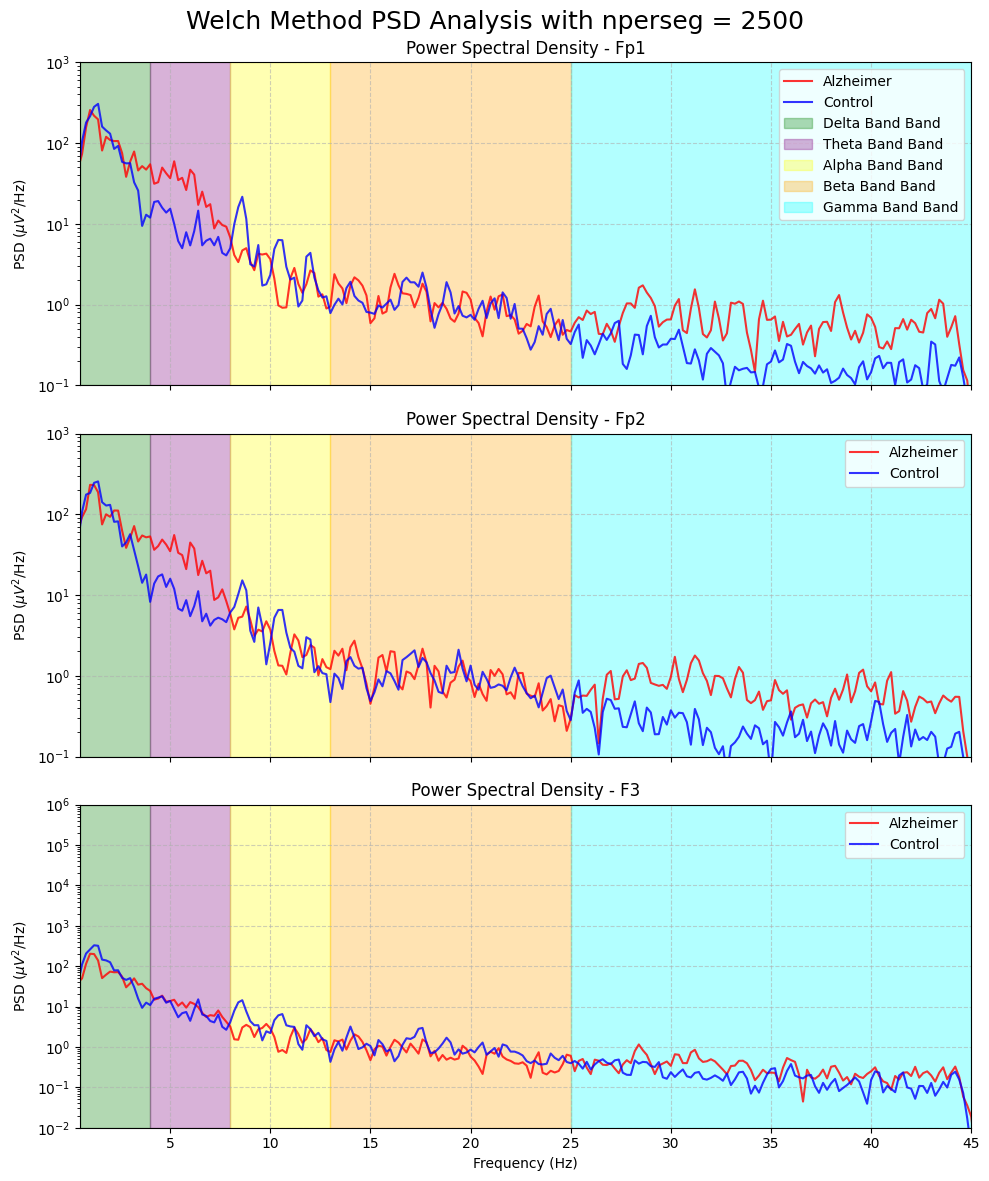

In [ ]:
plot_psd_Welch(df_AD_FIRfiltered, df_control_FIRfiltered, nperseg=2500)

You can see that there is high __frequency resolution__ but the curve looks __more noisier__ since there are fewer segments to average over. We can observe that the peaks in the __Delta__ and __Alpha__ bands are more sharp. 

However, we chose to stick with the value of 1500 because there was __sufficient frequency resolution__ to detect key EEG oscillations along with __minimal noise__ without over smoothing the PSD. 

# Conclusion
Our preliminary analysis of representative EEG recordings from the Miltiadous et al. (2023) dataset reveals that the Alzheimer patient's EEG consistently exhibits a prominent __Theta Band Peak__ in the 4-8 Hz range and __Gamma Band Peak__ in the 25-45 Hz range. The reduced Alpha band in AD group which is mentioned in the in Miltiadous et al. paper is also present in our findings, but not that significant compared with Theta and Gamma.  

There mismatch of our comparative analysis with the original dataset is expected, since the paper used all 88 patients, their results is more generative than ours. Extending our analysis to the full dataset would likely reveal the same significant differences in alpha power between AD patients and controls, as the paper suggested. The different behavior between frequency bands also support that Alzheimer’s disease is a complicated neural disorder which researchers should not rely on one single analysis as result, but our findings can be used as a supplementary material to help doctors with their diagnosis.

# Reference

1. Miltiadous, A., Tzimourta, K. D., Afrantou, T., Ioannidis, P., Grigoriadis, N., Tsalikakis, D. G., Angelidis, P., Tsipouras, M. G., Glavas, E., Giannakeas, N., & Tzallas, A. T. (2023). A Dataset of Scalp EEG Recordings of Alzheimer’s Disease, Frontotemporal Dementia and Healthy Subjects from Routine EEG. Data, 8(6), 95. https://doi.org/10.3390/data8060095
